## Redes neurais em finanças quantitativas

Olá, esse é um Modelo de Trading para o ativo mini Indice produzido com o intuito de mostrar a aplicação de ANN (Artificial Neural Network), para finanças quantitativas campo ao qual muito me interessa, e acredito que será útil aos senhores.

#### Etapas


- Passo 1 - Carregar as bibliotecas
- Passo 2 - Carregar a base de dados
- Passo 3 - Tratamento dos dados
- Passo 4 - Construçao dos alvos e variaveis
- Passo 5 - Preparaçao da base para treinamento e teste
- Passo 6 - Treinamento do modelo
- Passo 7 - Avaliaçao dos Resultados



________________________________________________________


### Passo 1 - Carregar as bibliotecas

In [1]:
# Carregando as bibliotecas
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np


In [2]:
# Para remover os warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


______________________________________________________

### Passo 2 - Carregar a base de dados

In [4]:
# Carregando a base de dados e fazendo os checks iniciais

df1 =pd.read_csv('/content/drive/My Drive/mini_indice_D1.csv', sep = ";")

df1.shape[0]

3752

In [5]:
df1.head()

,Data,Abertura,Maxima,Minima,Fechamento
0,17/05/2005,73165.43,73912.02,72269.53,73673.11
1,18/05/2005,73613.38,75106.56,73613.38,74807.92
2,19/05/2005,73912.02,74807.92,73882.16,74807.92
3,20/05/2005,74658.61,74658.61,73702.98,73912.02
4,23/05/2005,74210.65,74210.65,72717.48,72717.48


______________________________________________________

### Passo 3 - Tratamento dos dados

In [6]:
# Ajustando a data - precisamos transforma-la nos indices do data frame

df1["Data"] = pd.to_datetime(df1["Data"]).dt.normalize()

df1 = df1.set_index("Data")

In [7]:
df1.head()

,Abertura,Maxima,Minima,Fechamento
Data,,,,
2005-05-17,73165.43,73912.02,72269.53,73673.11
2005-05-18,73613.38,75106.56,73613.38,74807.92
2005-05-19,73912.02,74807.92,73882.16,74807.92
2005-05-20,74658.61,74658.61,73702.98,73912.02
2005-05-23,74210.65,74210.65,72717.48,72717.48


In [8]:
df1.describe()

,Abertura,Maxima,Minima,Fechamento
count,3752.000000,3752.000000,3752.000000,3752.000000
mean,95635.918526,96671.590912,94572.354379,95648.863875
std,23145.089648,23328.445878,22916.351093,23134.068335
min,47758.870000,48185.630000,47472.240000,47911.740000
25%,77696.530000,78775.280000,76932.057500,77820.900000
50%,91277.600000,92401.195000,90229.755000,91421.665000
75%,109679.395000,110796.505000,108756.457500,109818.387500
max,168747.430000,170782.460000,166849.590000,169330.500000


______________________________________________________

### Passo 4 - Construçao dos alvos e variaveis

In [9]:
# Construcao dos alvos

periodos = 1

# lag de X periodos
df1["Lag1"] = df1["Fechamento"].shift(-periodos)

# Alvo 1 - Retorno
df1["Retorno"] = df1["Fechamento"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variaçao em Pontos do alvo
df1["Pontos"] = (df1["Fechamento"] - df1["Fechamento"].shift(1))
df1["Pontos"] = df1["Pontos"].shift(-periodos)

In [10]:
df1["Retorno"].describe()

count    3751.000000
mean        0.000262
std         0.018516
min        -0.130041
25%        -0.009340
50%         0.000563
75%         0.010194
max         0.149722
Name: Retorno, dtype: float64

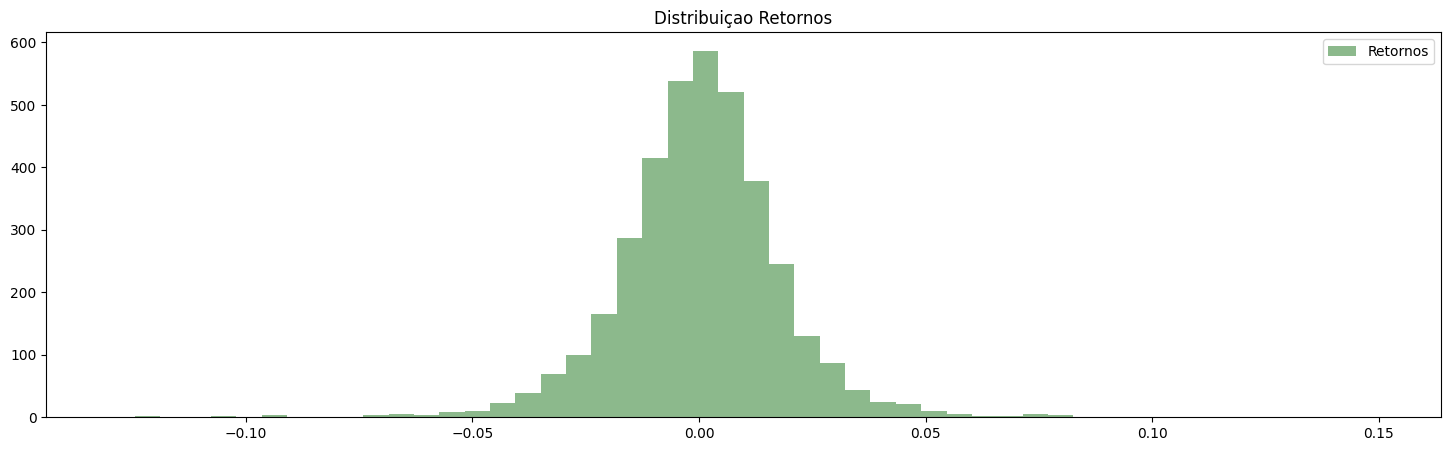

In [11]:
plt.figure(figsize = (18,5))
plt.hist(df1["Retorno"], bins = 50
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [12]:
# Criacao do alvo
df1["Alvo_Bin"] = np.where(df1['Alvo1'] > df1["Retorno"].describe()[6]/2 , 1
                           , np.where(df1['Alvo1'] < df1["Retorno"].describe()[4]/2, -1, 0))

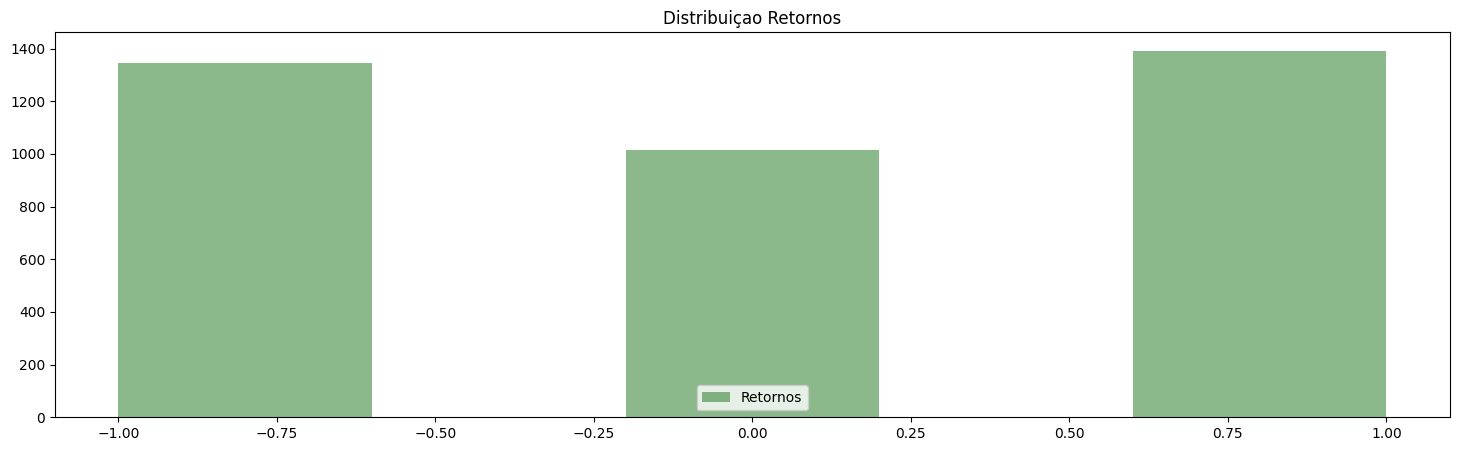

In [13]:
plt.figure(figsize = (18,5))
plt.hist(df1["Alvo_Bin"], bins = 5
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [14]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df1["std5"] = df1["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["Fechamento"]-df1["Abertura"])/(df1["Maxima"]-df1["Minima"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1['Fechamento'] > df1['Abertura'] , '1', '0')

# Direçao D-1
df1["dir_D-1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D-2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D-3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

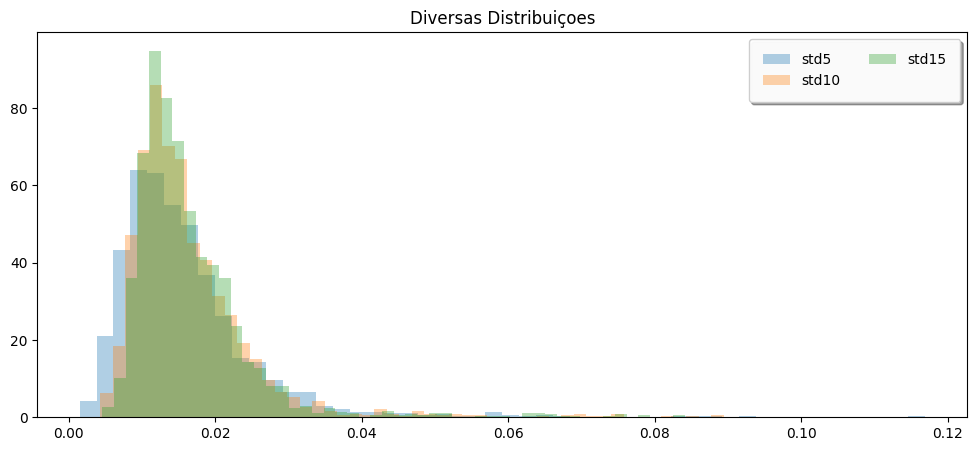

In [15]:
plt.figure(figsize = (12,5))
config = dict(histtype = 'stepfilled', alpha = 0.35, density = True, bins = 50)

plt.hist(df1["std5"], **config, label = "std5")
plt.hist(df1["std10"], **config, label = "std10")
plt.hist(df1["std15"], **config, label = "std15")

# Formataçao da legenda - Valida para qualquer tipo de grafico
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Diversas Distribuiçoes");

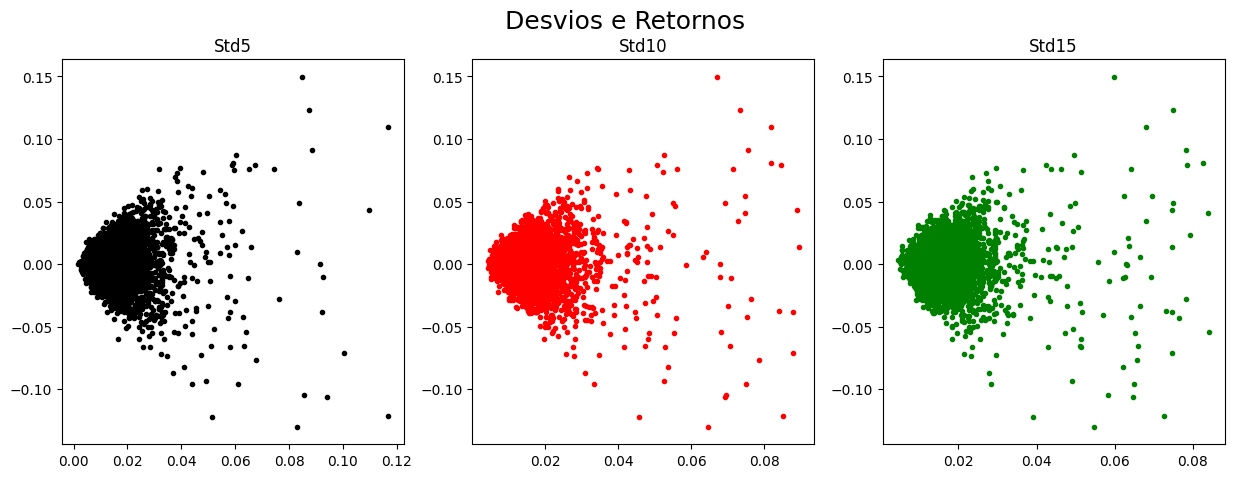

In [16]:
fig, axs = plt.subplots(1,3,figsize=(15, 5));
fig.suptitle("Desvios e Retornos", fontsize = 18);
axs[0].set_title('Std5')
axs[1].set_title('Std10')
axs[2].set_title('Std15')
axs[0].plot(df1["std5"], df1["Retorno"], ".", color = "black", label = "aleatorio")
axs[1].plot(df1["std10"], df1["Retorno"], ".", color = "red", label = "aleatorio")
axs[2].plot(df1["std15"], df1["Retorno"], ".", color = "green", label = "aleatorio");

In [17]:
pd.crosstab(pd.qcut(df1["RSL_std5"], 10, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,-1,0,1
RSL_std5,,,
0.0,3.491471,3.011727,3.464819
1.0,3.571429,2.985075,3.384861
2.0,3.917910,2.585288,3.438166
3.0,3.651386,2.531983,3.757996
4.0,3.518124,2.771855,3.678038
5.0,3.464819,2.665245,3.811301
6.0,3.438166,3.065032,3.438166
7.0,3.358209,2.825160,3.757996
8.0,3.198294,2.638593,4.104478


In [18]:
# Filtrando os valores missing

df1_filtrado = df1.dropna(axis = 0)

df1_filtrado= df1_filtrado.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1)

In [19]:
df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], 10, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], 10, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], 10, labels = False)

In [20]:
df1_filtrado.head()

,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15
Data,,,,,,,,,,,,,,,,,
2005-06-28,74836.91,74981.11,73971.75,74115.94,73712.20,0.001169,-0.005447,-403.74,-1,-0.714284,0,1,0,0,6,2,0
2005-06-29,74404.33,74981.11,73683.36,73712.20,73683.36,-0.005447,-0.000391,-28.84,0,-0.533331,0,0,1,0,6,1,0
2005-06-30,73827.55,74404.33,73539.16,73683.36,74260.14,-0.000391,0.007828,576.78,1,-0.166661,0,0,0,1,0,1,0
2005-01-07,74115.94,74260.14,73885.23,74260.14,73308.45,0.007828,-0.012816,-951.69,-1,0.384626,1,0,0,0,0,1,0
2005-04-07,73250.77,73712.20,73106.58,73308.45,71808.83,-0.012816,-0.020456,-1499.62,-1,0.095241,1,1,0,0,2,1,1


______________________________________________________

### Passo 5 - Preparaçao da base para treinamento e teste

In [21]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2005 à 2010
start_train = "2005-07-06"
end_train = "2010-12-31"

# Vamos testar o modelo de 2011 à 2020
start_test = "2011-01-01"
end_test = "2020-07-16"

df1_train1 = df1_filtrado[start_train : end_train]

df1_test1 = df1_filtrado[start_test : end_test]

In [22]:
df1_filtrado.columns

Index(['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Lag1', 'Retorno',
       'Alvo1', 'Pontos', 'Alvo_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15'],
      dtype='object')

In [23]:
# Separando os dados com as variaveis em x e o alvo em y

x_train1 = df1_train1.iloc[:, 9:16]
y_train1 = df1_train1['Alvo_Bin'].values.reshape(-1, 1)

x_test1 = df1_test1.iloc[:, 9:16]
y_test1 = df1_test1['Alvo_Bin'].values.reshape(-1, 1)

______________________________________________________

### Passo 6 - Treinamento do modelo

In [24]:
# Treinando o modelo

mlp1 = MLPClassifier(hidden_layer_sizes = (100,500,100), max_iter = 500,
                    solver = "sgd", verbose = 10, tol = 1e-8, random_state = 42,
                    learning_rate_init = .00005, learning_rate = "adaptive", activation = "tanh")

mlp1.verbose = False # as iterações do treinamento não serão mostradas na saída
mlp1.fit(x_train1, y_train1) # essa é a linha que treina o modelo!!!!

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 500, 100),
              learning_rate='adaptive', learning_rate_init=5e-05, max_iter=500,
              random_state=42, solver='sgd', tol=1e-08)

In [25]:
#(100, 500, 100), max_iter = 500,

In [26]:
# Prediçoes para o treinamento e teste

y_pred_train1 = mlp1.predict(x_train1)
y_pred_test1 = mlp1.predict(x_test1)

______________________________________________________

### Passo 7 - Avaliaçao dos Resultados

In [27]:
# Treinamento

print(confusion_matrix(y_train1, y_pred_train1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train1, y_pred_train1))

[[155   2 323]
 [110   1 219]
 [134   1 390]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.39      0.32      0.35       480
           0       0.25      0.00      0.01       330
           1       0.42      0.74      0.54       525

    accuracy                           0.41      1335
   macro avg       0.35      0.36      0.30      1335
weighted avg       0.37      0.41      0.34      1335



In [28]:
# Teste

print(confusion_matrix(y_test1, y_pred_test1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test1))

[[267   0 569]
 [215   1 446]
 [215   2 623]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.38      0.32      0.35       836
           0       0.33      0.00      0.00       662
           1       0.38      0.74      0.50       840

    accuracy                           0.38      2338
   macro avg       0.37      0.35      0.28      2338
weighted avg       0.37      0.38      0.31      2338



In [29]:
# Calculando a performance - para toda a base

y_pred_all = mlp1.predict(df1_filtrado.iloc[:, 9:16])

In [30]:
df1_filtrado.loc[: , "Previsto"] = y_pred_all
df1_filtrado.loc[: , "Retorno_Modelo"] = df1_filtrado.loc[: , "Previsto"]*df1_filtrado["Alvo1"]

#Simulando um stop de 3%

stop = 0.03
df1_filtrado.loc[: , "Retorno_Modelo"] = np.where(df1_filtrado.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_filtrado.loc[: , 'Retorno_Modelo'])

df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"] = df1_filtrado["Retorno_Modelo"].cumsum()

In [31]:
df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-10-07    5.265072
2020-07-13    5.288876
2020-07-14    5.302837
2020-07-15    5.314204
2020-07-16    5.290266
Name: Retorno_Modelo_Acumulado, dtype: float64

In [32]:
# Para fazer um conditional plot

df1_filtrado.index.name = "Date"
df1_filtrado.reset_index(inplace = True)

df1_filtrado["Date"] = pd.to_datetime(df1_filtrado["Date"])

df1_filtrado["train_test"] = np.where(df1_filtrado["Date"] > end_train, 1, -1)

In [33]:
df1_filtrado.head()

,Date,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,...,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,Previsto,Retorno_Modelo,Retorno_Modelo_Acumulado,train_test
0,2005-06-28,74836.91,74981.11,73971.75,74115.94,73712.20,0.001169,-0.005447,-403.74,-1,...,1,0,0,6,2,0,1,-0.005447,-0.005447,-1
1,2005-06-29,74404.33,74981.11,73683.36,73712.20,73683.36,-0.005447,-0.000391,-28.84,0,...,0,1,0,6,1,0,1,-0.000391,-0.005839,-1
2,2005-06-30,73827.55,74404.33,73539.16,73683.36,74260.14,-0.000391,0.007828,576.78,1,...,0,0,1,0,1,0,-1,-0.007828,-0.013666,-1
3,2005-01-07,74115.94,74260.14,73885.23,74260.14,73308.45,0.007828,-0.012816,-951.69,-1,...,0,0,0,0,1,0,-1,0.012816,-0.000851,-1
4,2005-04-07,73250.77,73712.20,73106.58,73308.45,71808.83,-0.012816,-0.020456,-1499.62,-1,...,1,0,0,2,1,1,-1,0.020456,0.019605,-1


In [34]:
base_agregada = df1_filtrado.resample("M", on = "Date").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

""


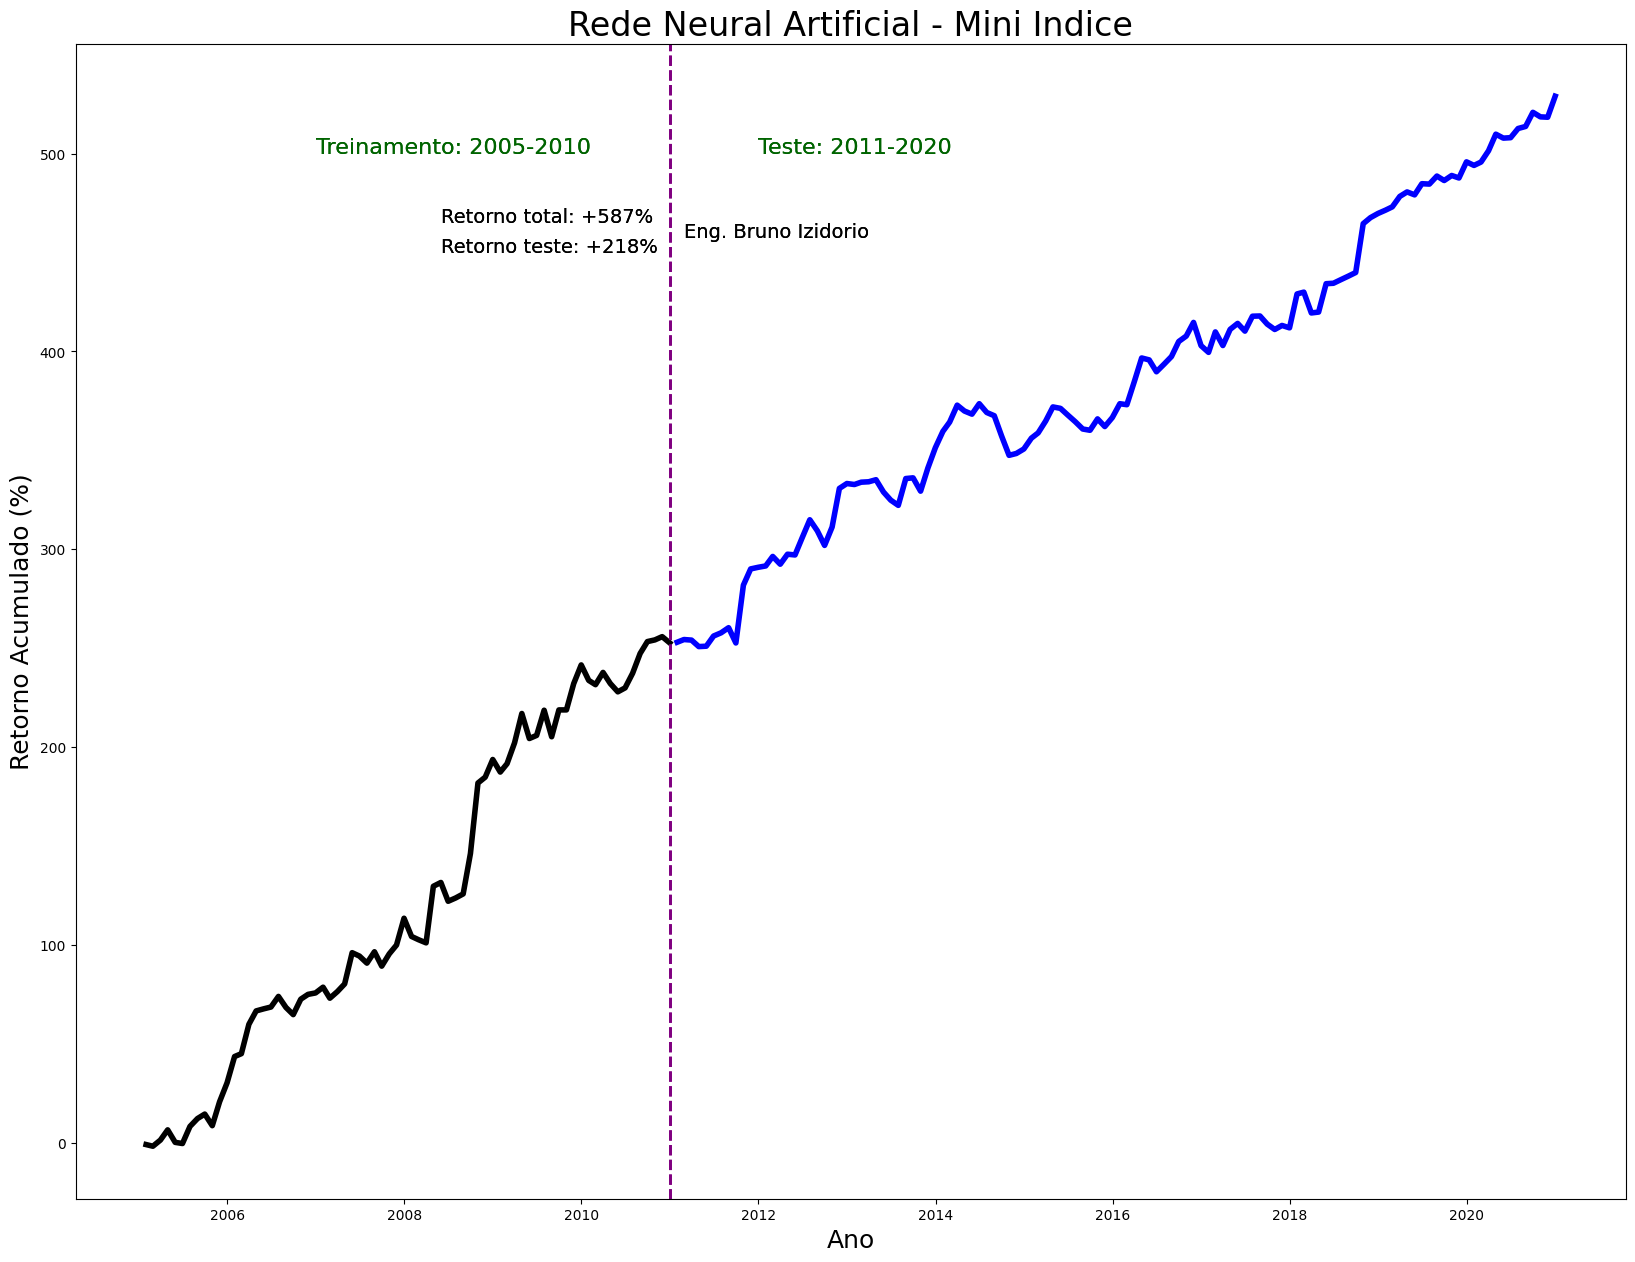

No charts were generated by quickchart


In [35]:
# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("Rede Neural Artificial - Mini Indice", fontsize = 24)
    plt.axvline( x = pd.to_datetime('2010-12-31'), color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")

    x1 = mdates.datestr2num("2007-01-01")
    x2 = mdates.datestr2num("2012-01-01")
    x3 = mdates.datestr2num("2008-06-01")
    x4 = mdates.datestr2num("2008-06-01")
    x5 = mdates.datestr2num("2011-03-01")

    ax.text(x1, 500, "Treinamento: 2005-2010", **setup)
    ax.text(x2, 500, "Teste: 2011-2020", **setup)
    ax.text(x3, 465, "Retorno total: +587%", **setup2)
    ax.text(x4, 450, "Retorno teste: +218%", **setup2)
    ax.text(x5, 457.5, "Eng. Bruno Izidorio", **setup2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)


In [36]:
# Calculando a performance - para a base de teste

df1_test1.loc[: , "Previsto"] = y_pred_test1
df1_test1.loc[: , "Retorno_Modelo"] = df1_test1.loc[: , "Previsto"]*df1_test1["Alvo1"]

#Simulando um stop de 3%

stop = 0.03
df1_test1.loc[: , "Retorno_Modelo"] = np.where(df1_test1.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_test1.loc[: , 'Retorno_Modelo'])

df1_test1.loc[: , "Retorno_Modelo_Acumulado"] = df1_test1["Retorno_Modelo"].cumsum()

In [37]:
df1_test1.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-07-07    2.574731
2020-07-13    2.598535
2020-07-14    2.612496
2020-07-15    2.623863
2020-07-16    2.599925
Name: Retorno_Modelo_Acumulado, dtype: float64

In [38]:
df1_test1.index.name = "Date"
df1_test1.reset_index(inplace = True)

df1_test1["Date"] = pd.to_datetime(df1_test1["Date"])

teste_agregado = df1_test1.resample("M", on = "Date").sum()

teste_agregado.loc[: , "Retorno_Modelo_Acumulado"] = teste_agregado["Retorno_Modelo"].cumsum()*100

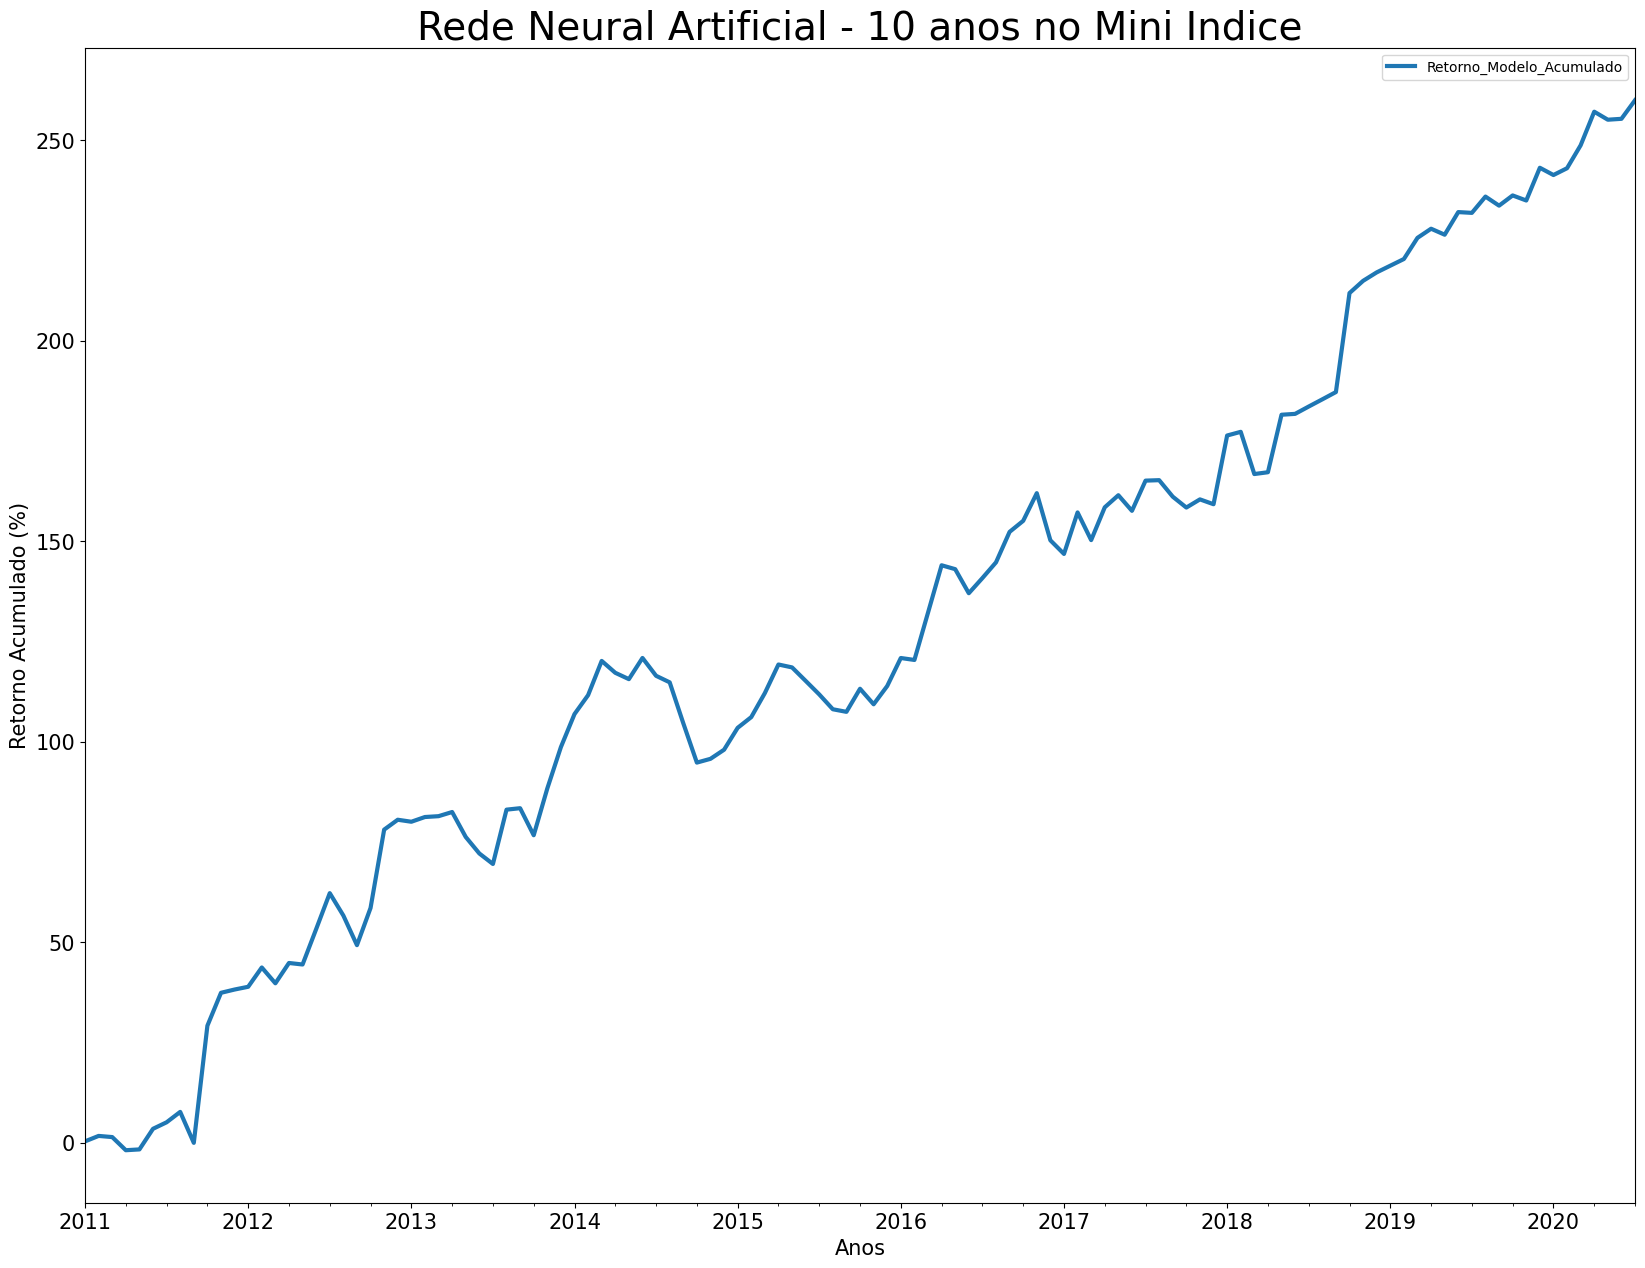

In [39]:
teste_agregado["Retorno_Modelo_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 15);
plt.title("Rede Neural Artificial - 10 anos no Mini Indice", fontsize = 28)
plt.legend()
plt.show()